In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


In [1]:
# https://keras.io/examples/structured_data/collaborative_filtering_movielens/

### (1) Load Data

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


In [3]:
str(ratings_file)

'/Users/nelsonlin/.keras/datasets/ml-latest-small/ratings.csv'

### (2) Processing

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# item to id
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [6]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [7]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [8]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [ ]:
print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

### (3) Prepare training and validation data

In [10]:
# shuffle
df = df.sample(frac=1, random_state=42)

In [11]:
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
# min max scale
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [12]:
x_train # ( user and movie)

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 589, 5054],
       [ 135,  636],
       [ 274, 3747]])

In [13]:
y_train #( rating )

array([0.88888889, 0.55555556, 0.55555556, ..., 0.55555556, 1.        ,
       0.11111111])

### (4) Create the model

In [69]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # https://keras.io/api/layers/initializers/#layer-weight-initializers
        # https://zhuanlan.zhihu.com/p/25110150

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        # user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        #  ? why  what is this for. This seeems useless
        # dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # print(f"dot_user_movie,{dot_user_movie}")
        # print(f"dot_user_movie.shape,{dot_user_movie.shape}")
        # print(f"user_bias.shape,{user_bias.shape}")
        # print(f"movie_bias.shape,{movie_bias.shape}")        
        # Add all the components (including bias)
        
        # x = dot_user_movie + user_bias + movie_bias
        x =  user_bias + movie_bias

        # The sigmoid activation forces the rating to between 0 and 1
        # print(f"x.shape,{x.shape}")        

        return tf.nn.sigmoid(x)

In [70]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

### (5) Training

In [71]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6576 - val_loss: 0.6351
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6208 - val_loss: 0.6164
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6069 - val_loss: 0.6090
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6004 - val_loss: 0.6056
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.5967 - val_loss: 0.6037


### (6) Plot training and validation loss

In [72]:
history.history

{'loss': [0.6575590968132019,
  0.6207506060600281,
  0.6069222688674927,
  0.6003996133804321,
  0.5967041850090027],
 'val_loss': [0.635106086730957,
  0.616441011428833,
  0.6090415120124817,
  0.6055669784545898,
  0.6037339568138123]}

In [68]:
history.history

{'loss': [0.6359355449676514,
  0.6134405136108398,
  0.6089725494384766,
  0.6082873344421387,
  0.6069095134735107],
 'val_loss': [0.6205803155899048,
  0.6189754605293274,
  0.6152071952819824,
  0.6122897267341614,
  0.6155612468719482]}

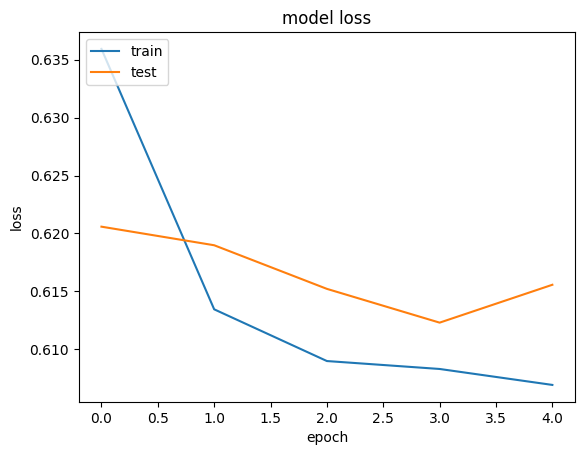

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


### (7) Show top 10 movie recommendations to a user

In [18]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [19]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]

In [20]:
movies_watched_by_user = df[df.userId == user_id]

In [21]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
48361,313,1449,5.0,1030557292,312,362
48453,313,2553,4.0,1030474757,312,2758
48345,313,1344,4.0,1030476305,312,4893
48448,313,2530,5.0,1030475005,312,2152
48251,313,163,3.0,1030556499,312,10
...,...,...,...,...,...,...
48302,313,1047,3.0,1030556484,312,1448
48447,313,2529,5.0,1030474684,312,164
48404,313,2023,3.0,1030556316,312,836
48354,313,1376,2.0,1030474810,312,1470


In [22]:
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

In [23]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

In [24]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

In [25]:
user_encoder = user2user_encoded.get(user_id)

In [26]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [27]:
user_movie_array

array([[ 312,    0],
       [ 312,  481],
       [ 312,    1],
       ...,
       [ 312, 3870],
       [ 312, 2989],
       [ 312, 7869]])

In [28]:
ratings = model.predict(user_movie_array).flatten()

294/294 [==============================] - 2s 5ms/step


In [29]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

In [30]:
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [31]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 313
Movies with high ratings from user
--------------------------------
Goodfellas (1990) : Crime|Drama
Raising Arizona (1987) : Comedy
Waiting for Guffman (1996) : Comedy
Watership Down (1978) : Adventure|Animation|Children|Drama|Fantasy
Omega Man, The (1971) : Action|Drama|Sci-Fi|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Schindler's List (1993) : Drama|War
One Flew Over the Cuckoo's Nest (1975) : Drama
Good Will Hunting (1997) : Drama|Romance
Office Space (1999) : Comedy|Crime
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
All the President's Men (1976) : Drama|Thriller
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Lives of Others, The (Das leben der Anderen) (2006) : Drama|Romance|Thriller
Departed, The (2006) : Crime|Drama|Thriller
Hurt Locker, The (2008) : Action|Drama|Thriller|War


### (8) Explore to learn

In [32]:
user_embedding = layers.Embedding(
            1000,
            128,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

In [33]:
movie_embedding = layers.Embedding(
            1000,
            128,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

In [34]:
inputs = x_train[:64]

In [35]:
user_vector = user_embedding(inputs[:, 0])

In [36]:
user_vector.shape

TensorShape([64, 128])

In [37]:
movie_vector = movie_embedding(inputs[:, 1])

In [38]:
movie_vector.shape

TensorShape([64, 128])

In [66]:
dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

In [63]:
dot_user_movie.shape

TensorShape([64, 128, 64, 128])

In [40]:
dot_user_movie + dot_user_movie

<tf.Tensor: shape=(), dtype=float32, numpy=-0.112682685>

In [56]:
user_bias = layers.Embedding(1000, 1)

movie_bias = layers.Embedding(1000, 1)

In [57]:
user_bias_vector = user_bias(inputs[:, 0])